<a href="https://colab.research.google.com/github/JoyceCristinee/Analise-de-Performance-de-E-commerce/blob/main/Script_de_An%C3%A1lise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. Gerando Dataset Sintético ---
Dataset bruto gerado: 1005 linhas.

--- 2. Limpeza e Amostragem ---
Linhas após deduplicação: 1000
Amostra efetiva para Logística (n): 985 (removidos 15 sem data)
Outliers de prazo detectados (IQR): 7


/tmp/ipython-input-3232336460.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_logistica, x='uf', y='delivery_lead_time', ax=axs[0, 1], palette="Set2")
/tmp/ipython-input-3232336460.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delay_rate, x='service_type', y='is_late', ax=axs[2, 0], palette="Reds_d")


Salvando imagem 'GRAFICOS.png' na pasta...


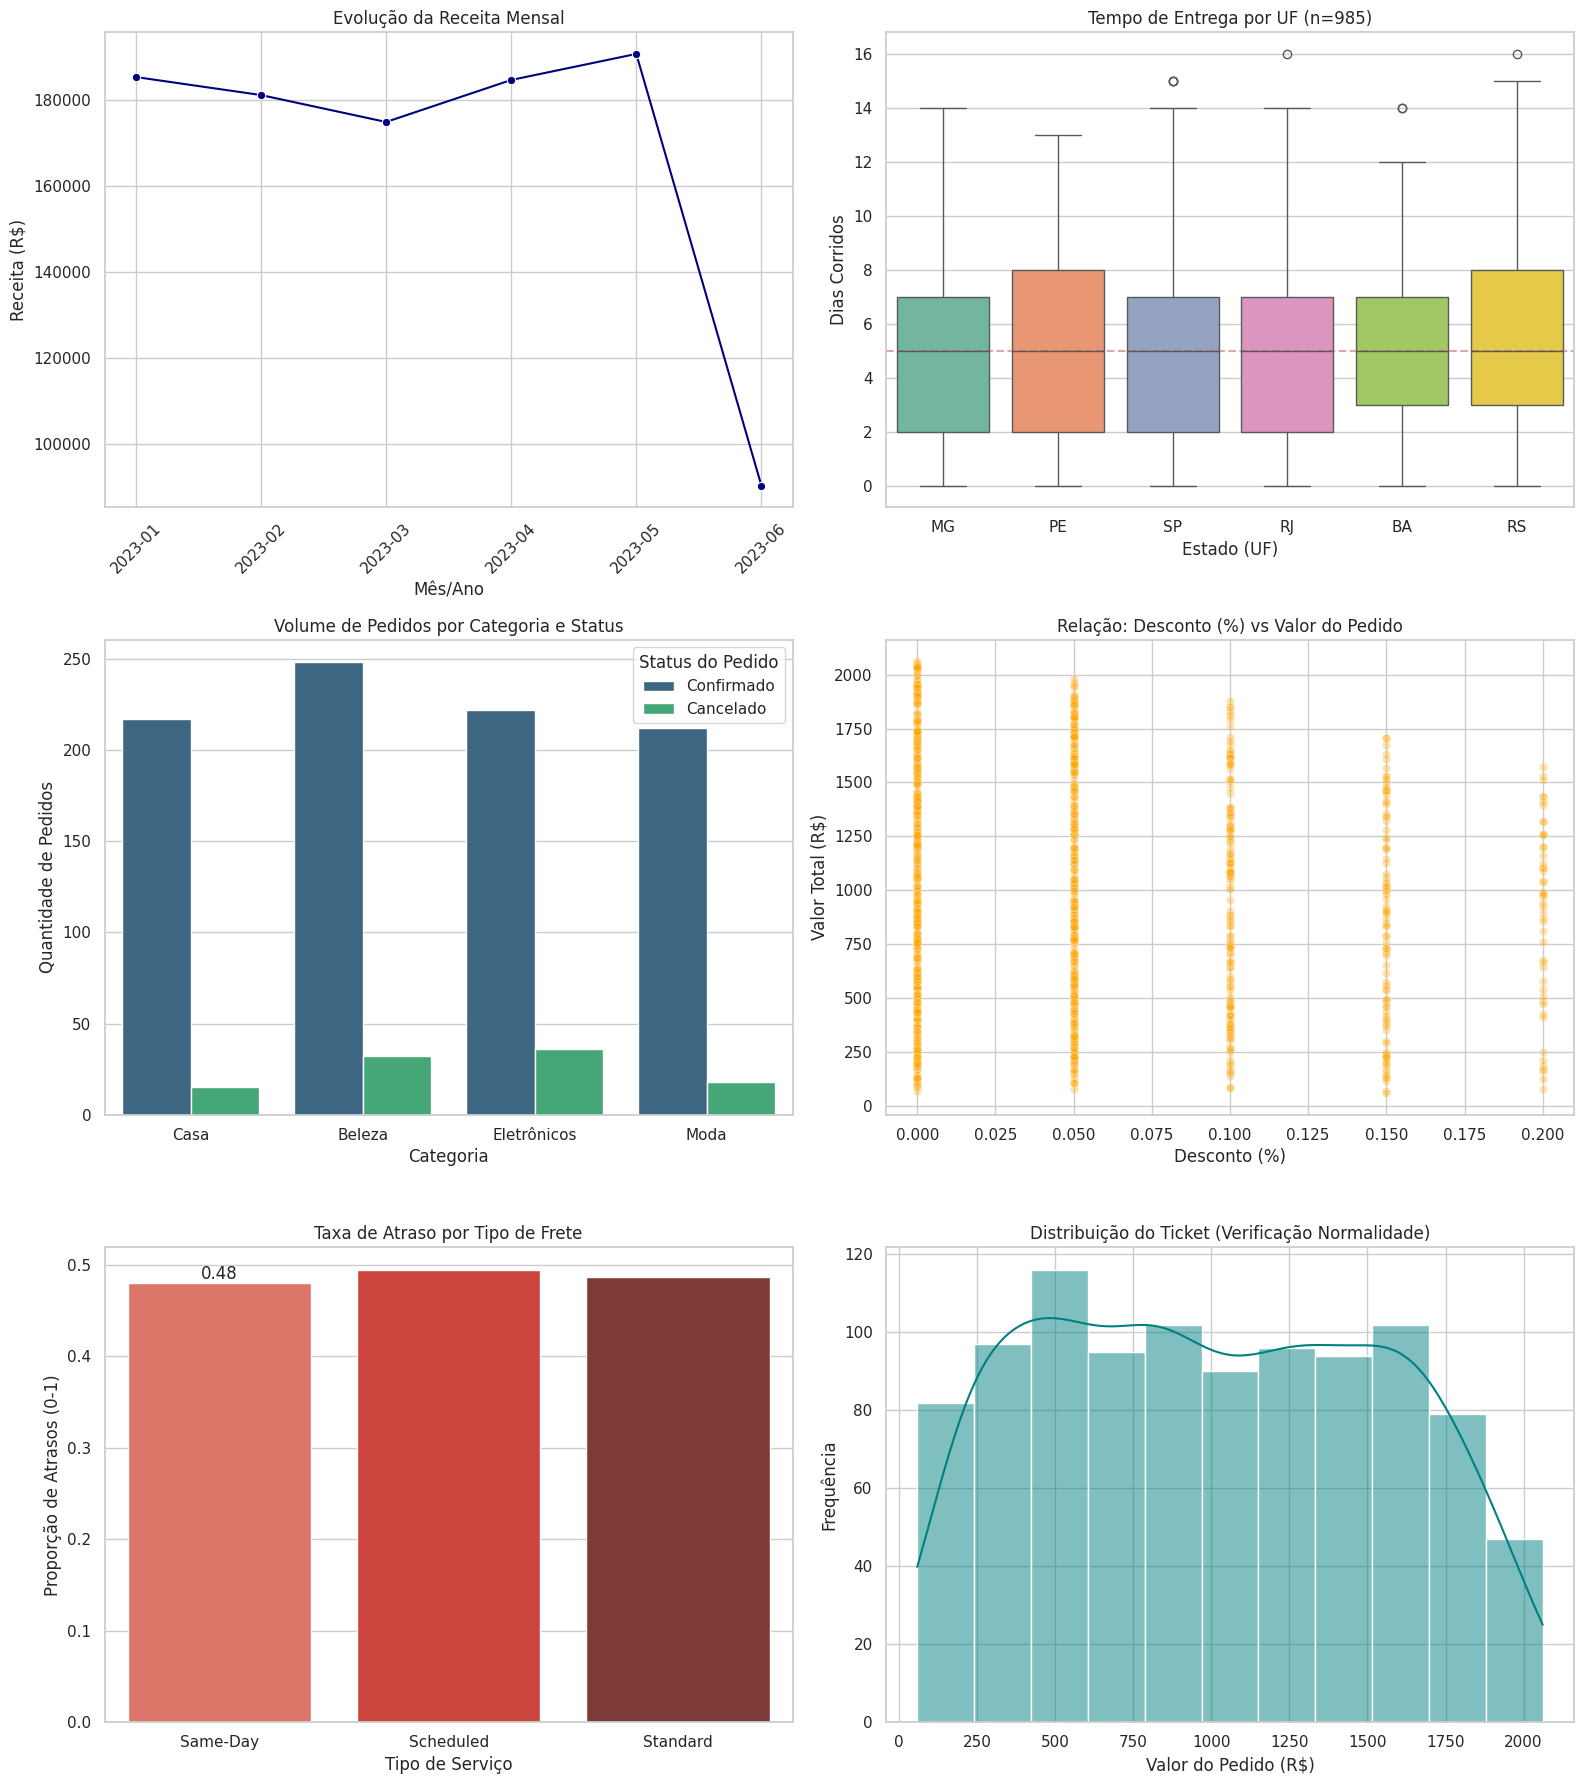


--- 3. Inferência Estatística ---
Ticket Médio: R$ 1006.55 (IC 95%: 973.10 - 1040.00)
Taxa de Atraso: 48.6% (IC 95%: 45.5% - 51.8%)

Teste de Normalidade (Shapiro-Wilk): p-value = 0.0000
-> Distribuição NÃO Normal (usar testes não-paramétricos ou Teorema Central do Limite)
Teste de Homocedasticidade (Levene SP vs RJ): p-value = 0.6617
Teste T (Médias SP vs RJ): p-value = 0.7842

       SUMÁRIO EXECUTIVO (KPIs)       
1. Receita Total Analisada:   R$ 1,006,547.86
2. Ticket Médio Global:       R$ 1006.55
3. Taxa de Conversão (Pgto):  89.9%
4. Taxa de Atraso Logístico:  48.6% (Base: 985 entregues)
5. Prazo Médio de Entrega:    5.1 dias

NOTA: Os dados foram gerados sinteticamente para fins de demonstração.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

print("--- 1. Gerando Dataset Sintético ---")
np.random.seed(42)

n_rows = 1000
data = {
    'order_id': [f'ORD-{i:05d}' for i in range(n_rows)],
    'order_date': pd.date_range(start='2023-01-01', periods=n_rows, freq='4h'),
    'category': np.random.choice(['Eletrônicos', 'Moda', 'Casa', 'Beleza'], n_rows),
    'uf': np.random.choice(['SP', 'RJ', 'MG', 'RS', 'PE', 'BA'], n_rows),
    'service_type': np.random.choice(['Standard', 'Same-Day', 'Scheduled'], n_rows, p=[0.7, 0.2, 0.1]),
    'purchase_status': np.random.choice(['Confirmado', 'Cancelado'], n_rows, p=[0.9, 0.1]),
    'subtotal': np.random.uniform(50, 2000, n_rows).round(2),
    'discount_pct': np.random.choice([0, 0.05, 0.10, 0.15, 0.20], n_rows, p=[0.4, 0.3, 0.15, 0.1, 0.05]),
}

df = pd.DataFrame(data)

df['d_forecast'] = df['order_date'] + pd.to_timedelta(np.random.randint(2, 10, n_rows), unit='D')
noise = np.random.normal(loc=0, scale=3, size=n_rows)
df['d_date'] = df['d_forecast'] + pd.to_timedelta(noise, unit='D')

mask_error = df['d_date'] < df['order_date']
df.loc[mask_error, 'd_date'] = df.loc[mask_error, 'order_date'] + pd.to_timedelta(1, unit='D')

df['p_service'] = np.random.uniform(10, 100, n_rows).round(2)
df['discount_abs'] = (df['subtotal'] * df['discount_pct']).round(2)
df['total'] = (df['subtotal'] + df['p_service'] - df['discount_abs']).round(2)

df.loc[0:14, 'd_date'] = np.nan
df = pd.concat([df, df.iloc[0:5]])

print(f"Dataset bruto gerado: {len(df)} linhas.")

print("\n--- 2. Limpeza e Amostragem ---")

df = df.drop_duplicates(subset='order_id')
n_dedup = len(df)
print(f"Linhas após deduplicação: {n_dedup}")

df_logistica = df.dropna(subset=['d_date']).copy()
n_logistica = len(df_logistica)
print(f"Amostra efetiva para Logística (n): {n_logistica} (removidos {n_dedup - n_logistica} sem data)")

for d in ['order_date', 'd_date', 'd_forecast']:
    df[d] = pd.to_datetime(df[d])
    df_logistica[d] = pd.to_datetime(df_logistica[d])

df_logistica['delivery_lead_time'] = (df_logistica['d_date'] - df_logistica['order_date']).dt.days
df_logistica['is_late'] = (df_logistica['d_date'] > df_logistica['d_forecast']).astype(int)

df['is_confirmed'] = (df['purchase_status'] == 'Confirmado').astype(int)
df['month_year'] = df['order_date'].dt.to_period('M')

Q1 = df_logistica['delivery_lead_time'].quantile(0.25)
Q3 = df_logistica['delivery_lead_time'].quantile(0.75)
IQR = Q3 - Q1
limite_sup = Q3 + 1.5 * IQR
outliers_n = len(df_logistica[df_logistica['delivery_lead_time'] > limite_sup])
print(f"Outliers de prazo detectados (IQR): {outliers_n}")

fig, axs = plt.subplots(3, 2, figsize=(16, 18))

sales_time = df.groupby('month_year')['total'].sum()
sales_time.index = sales_time.index.astype(str)
sns.lineplot(x=sales_time.index, y=sales_time.values, marker='o', ax=axs[0, 0], color='navy')
axs[0, 0].set_title('Evolução da Receita Mensal')
axs[0, 0].set_ylabel('Receita (R$)')
axs[0, 0].set_xlabel('Mês/Ano')
axs[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_logistica, x='uf', y='delivery_lead_time', ax=axs[0, 1], palette="Set2")
axs[0, 1].set_title(f'Tempo de Entrega por UF (n={n_logistica})')
axs[0, 1].set_ylabel('Dias Corridos')
axs[0, 1].set_xlabel('Estado (UF)')
axs[0, 1].axhline(y=df_logistica['delivery_lead_time'].median(), color='r', linestyle='--', alpha=0.5)

sns.countplot(data=df, x='category', hue='purchase_status', ax=axs[1, 0], palette="viridis")
axs[1, 0].set_title('Volume de Pedidos por Categoria e Status')
axs[1, 0].set_ylabel('Quantidade de Pedidos')
axs[1, 0].set_xlabel('Categoria')
axs[1, 0].legend(title='Status do Pedido')

sns.scatterplot(data=df, x='discount_pct', y='total', alpha=0.3, ax=axs[1, 1], color='orange')
axs[1, 1].set_title('Relação: Desconto (%) vs Valor do Pedido')
axs[1, 1].set_xlabel('Desconto (%)')
axs[1, 1].set_ylabel('Valor Total (R$)')

delay_rate = df_logistica.groupby('service_type')['is_late'].mean().reset_index()
sns.barplot(data=delay_rate, x='service_type', y='is_late', ax=axs[2, 0], palette="Reds_d")
axs[2, 0].set_title('Taxa de Atraso por Tipo de Frete')
axs[2, 0].set_ylabel('Proporção de Atrasos (0-1)')
axs[2, 0].set_xlabel('Tipo de Serviço')
axs[2, 0].bar_label(axs[2, 0].containers[0], fmt='%.2f')

sns.histplot(df['total'], kde=True, ax=axs[2, 1], color='teal')
axs[2, 1].set_title('Distribuição do Ticket (Verificação Normalidade)')
axs[2, 1].set_xlabel('Valor do Pedido (R$)')
axs[2, 1].set_ylabel('Frequência')

plt.tight_layout()
print("Salvando imagem 'GRAFICOS.png' na pasta...")
plt.savefig('GRAFICOS.png', dpi=300)
plt.show()

print("\n--- 3. Inferência Estatística ---")

mean_rev = df['total'].mean()
conf_int_rev = stats.norm.interval(0.95, loc=mean_rev, scale=stats.sem(df['total']))
print(f"Ticket Médio: R$ {mean_rev:.2f} (IC 95%: {conf_int_rev[0]:.2f} - {conf_int_rev[1]:.2f})")

n_late = df_logistica['is_late'].sum()
n_total_log = len(df_logistica)
ci_late = sms.proportion_confint(count=n_late, nobs=n_total_log, method='wilson')
print(f"Taxa de Atraso: {(n_late/n_total_log)*100:.1f}% (IC 95%: {ci_late[0]*100:.1f}% - {ci_late[1]*100:.1f}%)")

stat_shapiro, p_shapiro = stats.shapiro(df['total'])
print(f"\nTeste de Normalidade (Shapiro-Wilk): p-value = {p_shapiro:.4f}")
print("-> Distribuição Normal" if p_shapiro > 0.05 else "-> Distribuição NÃO Normal (usar testes não-paramétricos ou Teorema Central do Limite)")

sp = df[df['uf'] == 'SP']['total']
rj = df[df['uf'] == 'RJ']['total']
stat_levene, p_levene = stats.levene(sp, rj)
print(f"Teste de Homocedasticidade (Levene SP vs RJ): p-value = {p_levene:.4f}")

t_stat, p_val_t = stats.ttest_ind(sp, rj, equal_var=(p_levene > 0.05))
print(f"Teste T (Médias SP vs RJ): p-value = {p_val_t:.4f}")

receita_total = df['total'].sum()
mean_lead = df_logistica['delivery_lead_time'].mean()
taxa_conversao = df['is_confirmed'].mean() * 100
taxa_atraso_pct = (n_late / n_total_log) * 100

print("\n" + "="*40)
print("       SUMÁRIO EXECUTIVO (KPIs)       ")
print("="*40)
print(f"1. Receita Total Analisada:   R$ {receita_total:,.2f}")
print(f"2. Ticket Médio Global:       R$ {mean_rev:.2f}")
print(f"3. Taxa de Conversão (Pgto):  {taxa_conversao:.1f}%")
print(f"4. Taxa de Atraso Logístico:  {taxa_atraso_pct:.1f}% (Base: {n_total_log} entregues)")
print(f"5. Prazo Médio de Entrega:    {mean_lead:.1f} dias")
print("="*40)
print("\nNOTA: Os dados foram gerados sinteticamente para fins de demonstração.")